# Singular Learning Theory (SLT)

Sources:
- [Neural networks generalize because of this one weird trick](https://www.lesswrong.com/posts/fovfuFdpuEwQzJu2w/neural-networks-generalize-because-of-this-one-weird-trick)
- [DSLT 1. The RLCT Measures the Effective Dimension of Neural Networks](https://www.lesswrong.com/s/czrXjvCLsqGepybHC/p/4eZtmwaqhAgdJQDEg)

Last updated: October 15, 2024

Time taken: k hours, 2 < k < 10

## Setup

In [8]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from scipy import stats
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader


Though deep learning has shown remarkable success in a wide range of applications, the theoretical underpinnings of deep learning have remained somewhat elusive. Why do massively overparameterized neural networks generalize so well? How can we rigorously analyze the behavior of these complex models?

Singular Learning Theory (SLT) is a groundbreaking mathematical framework developed by Sumio Watanabe. It focuses on 'singular' models like neural networks, mixture models and hidden Markov models, and tries to understand behavior of these complex statistical models. In this nobebook, we explore some of the key concepts of SLT.

First of all, note that there exist various limitations in classical statistical theory, espcially when applied to modern-day machine learning models. For example, traditional approaches often rely on regularity conditions that simply don't hold for neural networks and other flexible model classes. These conditions typically assume that the Fisher information matrix is non-degenerate, which is rarely the case in complex models. Recognizing that there is this gap, Watanabe tried to develop a theory that could handle such 'singular' cases, by incorporating sophisticated techniques that draw inspiration from resolution of singularities in algebraic geometry. By doing so, he extended statistical analyses to more complex scenarios, and gave insight on how we can understand their learning behavior.

## Table of contents
- 1. Regular vs. singular models?
    - 1.1 Regular models
    - 1.2 Singular models

- 2. Real log canonical threshold
- 3. Watanabe's free energy formula
- 4. SLT and neural networks
- 5. Implementation (example)
- 6. Conclusion

## 1. Regular vs. singular models?

The distinction between regular and singular models lies at the heart of singular learning theory. We will attempt to explore these concepts below:

### 1.1 Regular models

#### Definition (Regular model)

A statistical model is considered regular if it satisfies certain smoothness and non-degeneracy conditions. Formally, a parametric model {p(x|w) : w ∈ W ⊆ ℝᵈ} is regular if the following conditions are true.

First, it's identifiable. That is, distinct parameter values correspond to distinct probability distributions.
Next, the log-likelihood function is smooth. Specifically, it is three times continuously differentiable.
Finally, the Fisher information matrix is positive definite, for all parameter values.

#### Example (Regular model)

A classic example of a regular model would be linear regression with Gaussian noise. The log-likelihood is quadratic in the parameters, leading to a constant, positive definite Fisher information matrix. We implement a toy example here.

Estimated parameters: intercept=1.02, slope=1.99


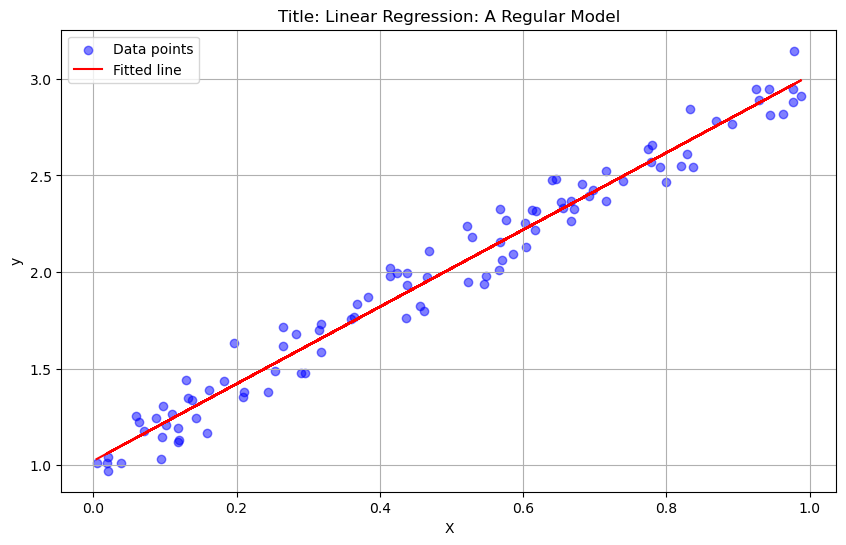

In [29]:
# Generate sample data
np.random.seed(0)
X = np.random.rand(100, 1)
y = 2 * X + 1 + np.random.randn(100, 1) * 0.1
# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)
print(f"Estimated parameters: intercept={model.intercept_[0]:.2f}, slope={model.coef_[0][0]:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Data points')
plt.plot(X, model.predict(X), color='red', label='Fitted line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Title: Linear Regression: A Regular Model')
plt.legend()
plt.grid(True)
plt.show()

This is a plot showing the data points and the fitted line, and illustrates the concept of a regular model.

### 1.2 Singular models

#### Definition (Singular model)

A model is considered singular if it violates one or more of the conditions below. 

First, it must have permutation symmetry. That is, reordering hidden units doesn't change the function.
Next, it should also have scaling symmetry. For example, for ReLU activations, scaling weights in one layer can be compensated by inverse scaling in the next layer.
Finally, there exist redundant units. That is, some hidden units may effectively have zero weight.

We learnt that symmetries and redundancies lead to a degenerate Fisher information matrix, which has profound implications for the learning dynamics and asymptotic behavior of these models.

#### Example (Singular model)

A prime example of a singular model would be a neural networks. We visualize the permutation symmetry below.

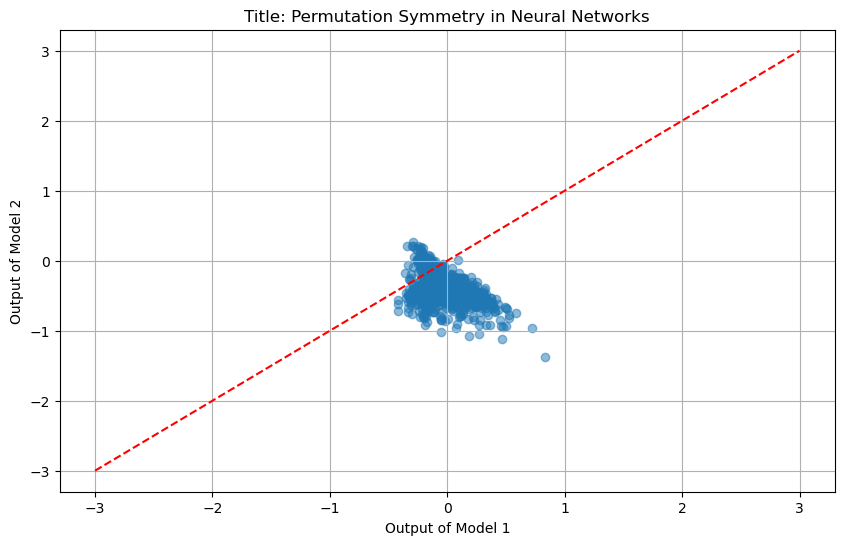

In [30]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(10, 5)
        self.layer2 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Two identical models
model1 = SimpleNN()
model2 = SimpleNN()
# Permute order of neurons in hidden layer
with torch.no_grad():
    model2.layer1.weight = nn.Parameter(model1.layer1.weight[torch.randperm(5)])
    model2.layer1.bias = nn.Parameter(model1.layer1.bias[torch.randperm(5)])
    model2.layer2.weight = nn.Parameter(model2.layer2.weight[:, torch.randperm(5)])

torch.manual_seed(0)
X = torch.randn(1000, 10)
# Get outputs from both models
output1 = model1(X).detach().numpy()
output2 = model2(X).detach().numpy()

plt.figure(figsize=(10, 6))
plt.scatter(output1, output2, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')  # Diagonal line
plt.xlabel('Output of Model 1')
plt.ylabel('Output of Model 2')
plt.title('Title: Permutation Symmetry in Neural Networks')
plt.grid(True)
plt.show()

This plot shows that despite the permutation of hidden units, both models produce nearly identical outputs, illustrating the permutation symmetry of neural networks.

## 2. Real log canonical threshold

SLT introduces the notion of the Real Log Canonical Threshold (RLCT), denoted by λ. This is a measure that generalizes the concept of degrees of freedom to singular models, and provides a more nuanced understanding of model capacity beyond simple parameter counting.

Note for a statistical model with parameter space W and Kullback-Leibler divergence K(w) from the true distribution, the RLCT is defined to be λ = lim_{ε→0} [log V(ε) / log ε], where V(ε) is the volume of the set of parameters with KL divergence less than ε.

To visualize this concept, we will try plotting the log-log relationship between V(ε) and ε.

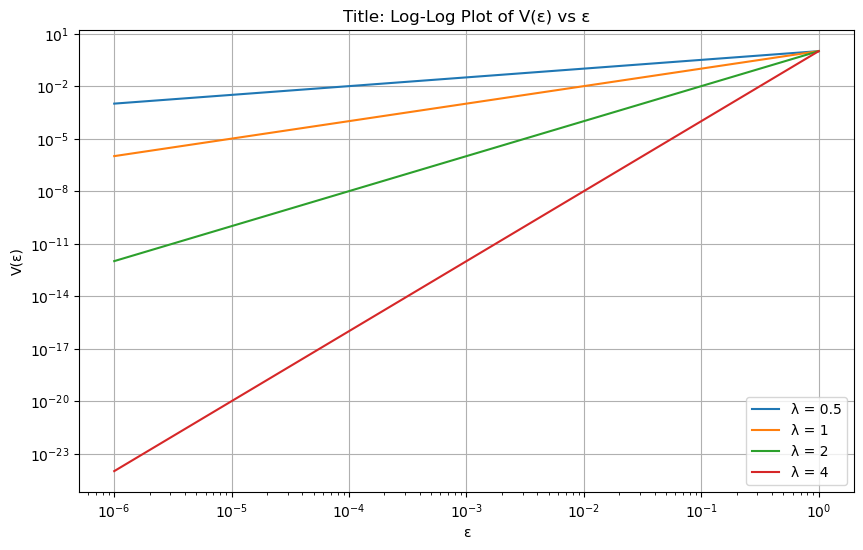

In [31]:
def V(epsilon, lambda_rlct):
    return epsilon ** lambda_rlct

epsilons = np.logspace(-6, 0, 100)
lambdas = [0.5, 1, 2, 4]

plt.figure(figsize=(10, 6))
for lambda_rlct in lambdas:
    V_values = V(epsilons, lambda_rlct)
    plt.loglog(epsilons, V_values, label=f'λ = {lambda_rlct}')

plt.title('Title: Log-Log Plot of V(ε) vs ε')
plt.xlabel('ε')
plt.ylabel('V(ε)')
plt.legend()
plt.grid(True)
plt.show()

What this log-log plot illustrates is how V(ε) scales with ε for varying values of λ (RLCT).

In regular models with d parameters, λ = d/2, which aligns with our classical understanding of model complexity. 

However, for singular models, λ ≤ d/2, and it is usually a positive rational number. This captures the idea that singular models may have an effective dimensionality lower than their parameter count due to the inherent symmetries and redundancies.

We learn that the RLCT has some very important implications for learning and generalization. First, it (i) determines the asymptotic learning rate. That is, for a model with RLCT λ, the generalization error typically scales as O(n^(-1/(2λ))). Here, n is the sample size. Next, it shows that (ii) models with lower RLCT tend to generalize better, offering a theoretical explanation for why overparameterized models can perform well. Finally, it (iii) provides a basis for model selection in singular settings, generalizing concepts like the Bayesian Information Criterion (BIC).

## 3. Watanabe's free energy formula

Watanabe's asymptotic formula for the free energy of singular models is also an important contribution. It is written as Fn = nL(w0) + λ log n - (m - 1) log log n + Op(1).

Here, note that L(w0) is the expected log loss of the true distribution, λ is the RLCT, m is the multiplicity of the RLCT, and Op(1) is a term that is bounded in probability as n → ∞.

This formula helps to generalize the classical BIC to singular models in several key ways. First, it (i) replaces d/2, which is half the number of parameters, with λ, allowing for non-integer "effective dimensions." Next, it (ii) introduces the log log n term to account for multiplicities in singular models. Third, it (iii) provides a rigorous asymptotic result, while BIC is typically derived through rougher approximations.

We can now visualize how this free energy changes with the sample size for varying RLCT values.

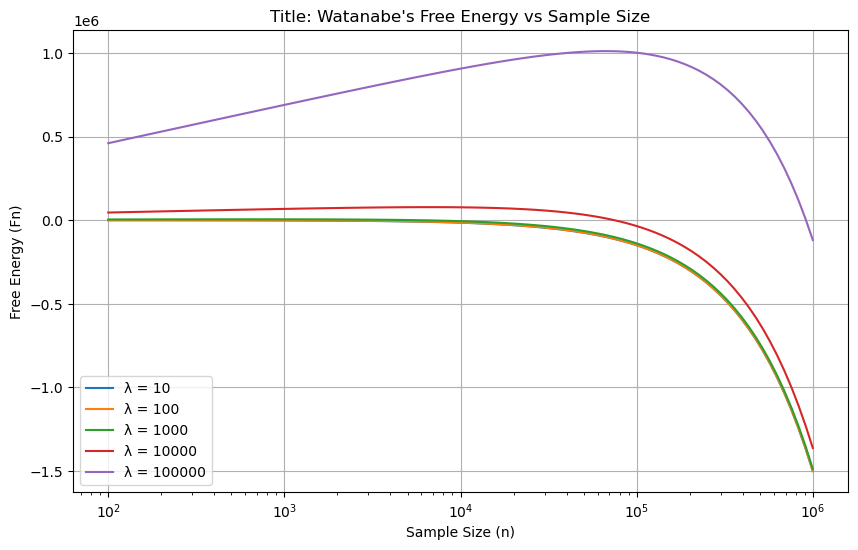

In [34]:
# Define helper for free energy
def watanabe_free_energy(n, L_w0, lambda_rlct, m):
    return n * L_w0 + lambda_rlct * np.log(n) - (m - 1) * np.log(np.log(n))

n_values = np.logspace(2, 6, 100)
L_w0 = -1.5
lambdas = [10, 100, 1000, 10000, 100000]
m = 2
plt.figure(figsize=(10, 6))

for lambda_rlct in lambdas:
    F_n = watanabe_free_energy(n_values, L_w0, lambda_rlct, m)
    plt.semilogx(n_values, F_n, label=f'λ = {lambda_rlct}')

plt.title("Title: Watanabe's Free Energy vs Sample Size")
plt.xlabel('Sample Size (n)')
plt.ylabel('Free Energy (Fn)')
plt.legend()
plt.grid(True)
plt.show()

This plot shows how the free energy changes with sample size for different RLCT values, which helps to illustrate the impact of model complexity on the learning process.

We recognize that the implications of this formula are far-reaching. It provides a theoretical foundation for model selection in singular settings through the Widely Applicable Information Criterion (WAIC). It also offers insights into learning dynamics, suggesting that learning in singular models might proceeds more slowly than in regular models.

## 4. SLT and neural networks

SLT predicts that the generalization error E of a neural network scales as
E ∼ O(n^(-1/2λ)). We visualize this relationship here.

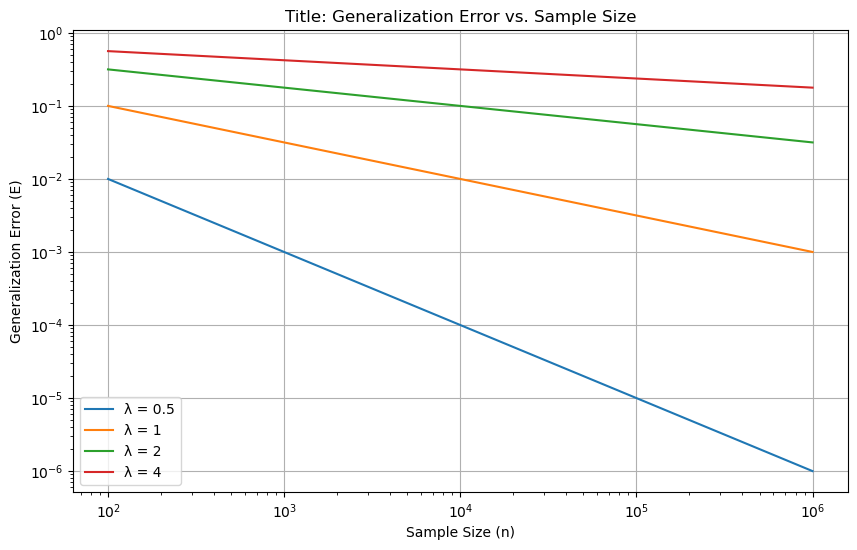

In [35]:
# Define helper for generalization error
def gen_error(n, lambda_rlct):
    return n ** (-1 / (2 * lambda_rlct))

n = np.logspace(2, 6, 100)
lambdas = [0.5, 1, 2, 4]

plt.figure(figsize=(10, 6))
for lambda_rlct in lambdas:
    E = gen_error(n, lambda_rlct)
    plt.loglog(n, E, label=f'λ = {lambda_rlct}')

plt.title('Title: Generalization Error vs. Sample Size')
plt.xlabel('Sample Size (n)')
plt.ylabel('Generalization Error (E)')
plt.legend()
plt.grid(True)
plt.show()

What this is showing is how the generalization error decreases with increasing sample size, and how this relationship is affected by different values of the RLCT.

# 5. Implementation (example)

Note this implementation was optimized for memory.

In [20]:
class SingularLearningTheory:
    def __init__(self, model, true_distribution, prior):
        self.model = model
        self.true_distribution = true_distribution
        self.prior = prior

    def compute_free_energy(self, x, n):
        def negative_log_likelihood(w):
            return -np.sum(np.log(self.model(x, w) + 1e-10))
        if isinstance(self.prior, np.ndarray):
            initial_guess = self.prior
        elif isinstance(self.prior, (int, float)):
            initial_guess = np.array([self.prior])
        elif hasattr(self.prior, 'mean') and callable(self.prior.mean):
            initial_guess = self.prior.mean()
        elif hasattr(self.prior, 'rvs') and callable(self.prior.rvs):
            initial_guess = self.prior.rvs()
        else:
            raise ValueError("Unable to determine initial guess from prior")
        result = minimize(negative_log_likelihood, initial_guess, method='L-BFGS-B')
        w_mle = result.x
        L_n = negative_log_likelihood(w_mle) / n
        lambda_hat = self.estimate_rlct(n_samples=min(n, 1000))
        return n * L_n + lambda_hat * np.log(n)

    def compute_waic(self, x, n_samples=1000):
        if hasattr(self.prior, 'rvs') and callable(self.prior.rvs):
            w_samples = self.prior.rvs(n_samples)
        else:
            w_samples = np.linspace(-10, 10, n_samples).reshape(-1, 1)
        log_likelihoods = np.array([[np.log(self.model(xi.reshape(1, -1), w) + 1e-10) for xi in x] for w in w_samples])
        lppd = np.sum(logsumexp(log_likelihoods, axis=0) - np.log(n_samples))
        p_waic = np.sum(np.var(log_likelihoods, axis=0))
        waic = -2 * (lppd - p_waic)
        return waic

    def compute_volume(self, x, epsilon):
        w_samples = self.prior.rvs(1000)
        kl_values = np.array([self.kl_divergence(w, x) for w in w_samples])
        return np.mean(kl_values < epsilon)

    def estimate_rlct(self, n_samples=1000, epsilon_range=np.logspace(-5, 0, 50)):
        x = self.true_distribution.rvs(n_samples)
        volumes = []
        for epsilon in epsilon_range:
            volume = self.compute_volume(x, epsilon)
            volumes.append(volume)
        log_volumes = np.log(volumes)
        log_epsilons = np.log(epsilon_range)
        slope, _ = np.polyfit(log_epsilons, log_volumes, 1)
        # Return negative slope as real log canonical threshold
        return -slope

    def kl_divergence(self, w, x):
        p_true = self.true_distribution.pdf(x)
        p_model = self.model(x, w)
        return np.mean(np.log(p_true + 1e-10) - np.log(p_model + 1e-10))

/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)


Estimated RLCT for singular model: -0.0035031006312807996


/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)
/var/folde

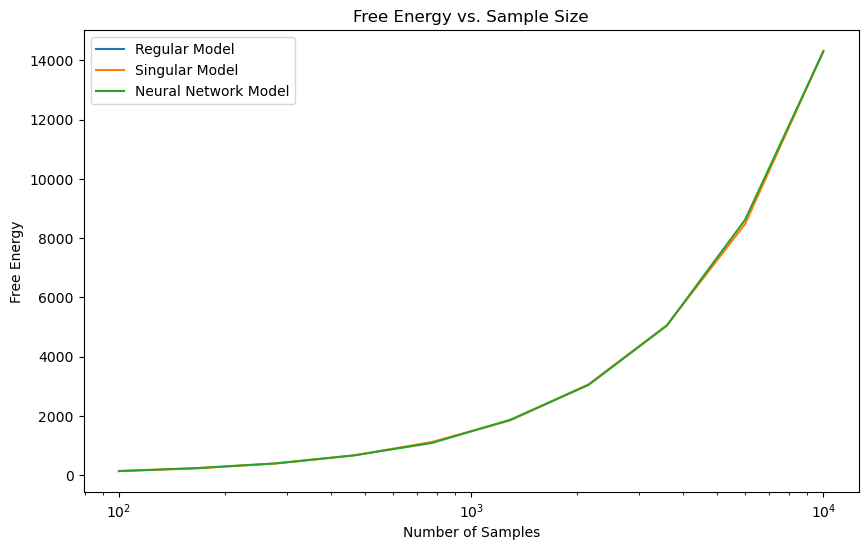

In [23]:
class RegularModel:
    def __init__(self, d):
        self.d = d

    def __call__(self, x, w):
        return multivariate_normal(mean=w, cov=np.eye(self.d)).pdf(x)

class SingularModel:
    def __init__(self, d):
        self.d = d

    def __call__(self, x, w):
        return multivariate_normal(mean=[w[0]**2], cov=np.eye(1)).pdf(x[:, 0])

class SimpleNeuralNetworkModel:
    def __init__(self, hidden_layer_sizes, input_dim, output_dim):
        self.nn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=1000)
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_fitted = False

    def fit(self, X, y):
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
        self.nn.fit(X_scaled, y_scaled)
        self.is_fitted = True

    def __call__(self, x, w=None):
        if not self.is_fitted:
            raise ValueError("Model is not fitted yet. Call 'fit' with appropriate data first.")
        X = x[:, :self.input_dim]
        X_scaled = self.scaler_X.transform(X)
        y_pred_scaled = self.nn.predict(X_scaled)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        # Convert predictions to probability density
        # Note this assumes Gaussian noise with unit variance
        return np.exp(-0.5 * (x[:, -1] - y_pred)**2) / np.sqrt(2 * np.pi)

    def get_params(self):
        return self.nn.coefs_ + self.nn.intercepts_

    def set_params(self, params):
        n_layers = len(self.nn.hidden_layer_sizes) + 1
        sizes = [self.input_dim] + list(self.nn.hidden_layer_sizes) + [self.output_dim]
        self.nn.coefs_ = params[:n_layers]
        self.nn.intercepts_ = params[n_layers:]
        for i in range(n_layers):
            self.nn.coefs_[i] = self.nn.coefs_[i].reshape(sizes[i], sizes[i+1])
            self.nn.intercepts_[i] = self.nn.intercepts_[i].reshape(-1)

d = 2
true_dist = multivariate_normal(mean=[0, 0], cov=np.eye(d))
prior = multivariate_normal(mean=np.zeros(d), cov=np.eye(d))

regular_model = RegularModel(d)
singular_model = SingularModel(d)
nn_model = SimpleNeuralNetworkModel(hidden_layer_sizes=(5, 5), input_dim=d-1, output_dim=1)

slt_regular = SingularLearningTheory(regular_model, true_dist, prior)
slt_singular = SingularLearningTheory(singular_model, true_dist, prior)
slt_nn = SingularLearningTheory(nn_model, true_dist, prior)
# Generate data to fit the neural network
X_train = true_dist.rvs(1000)
nn_model.fit(X_train[:, :-1], X_train[:, -1])
# Estimate RLCT
rlct_regular = slt_regular.estimate_rlct()
rlct_singular = slt_singular.estimate_rlct()
rlct_nn = slt_nn.estimate_rlct()

# Sanity check
print(f"Estimated RLCT for singular model: {rlct_singular}")
# Compute free energy for different sample sizes
n_samples = np.logspace(2, 4, 10).astype(int)
fe_regular = []
fe_singular = []
fe_nn = []
for n in n_samples:
    x = true_dist.rvs(n)
    fe_regular.append(slt_regular.compute_free_energy(x, n))
    fe_singular.append(slt_singular.compute_free_energy(x, n))
    fe_nn.append(slt_nn.compute_free_energy(x, n))

plt.figure(figsize=(10, 6))
plt.plot(n_samples, fe_regular, label='Regular Model')
plt.plot(n_samples, fe_singular, label='Singular Model')
plt.plot(n_samples, fe_nn, label='Neural Network Model')
plt.xscale('log')
plt.xlabel('Number of Samples')
plt.ylabel('Free Energy')
plt.title('Title: Free Energy vs. Sample Size')
plt.legend()
plt.show()

We see that all three models show increasing free energy with sample size, which is expected.

/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)


Estimated RLCT (Regular): nan
Estimated RLCT (Singular): -0.0028784504920342426


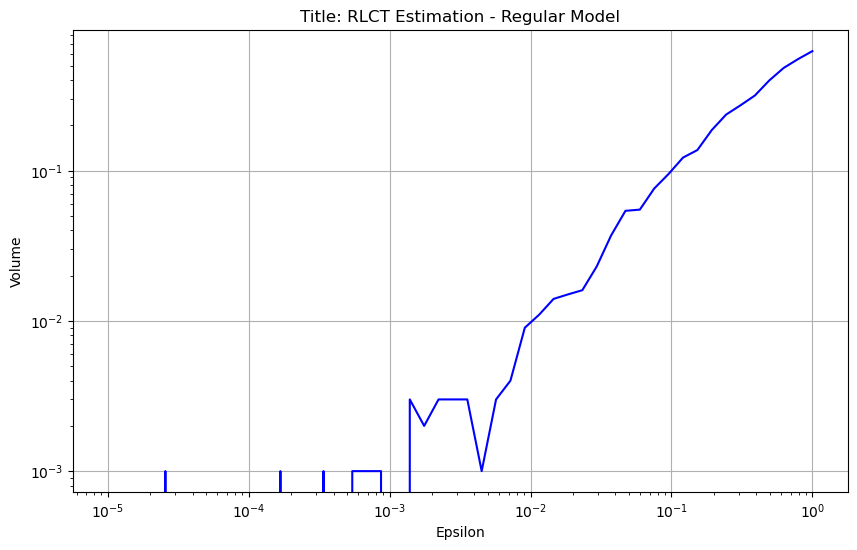

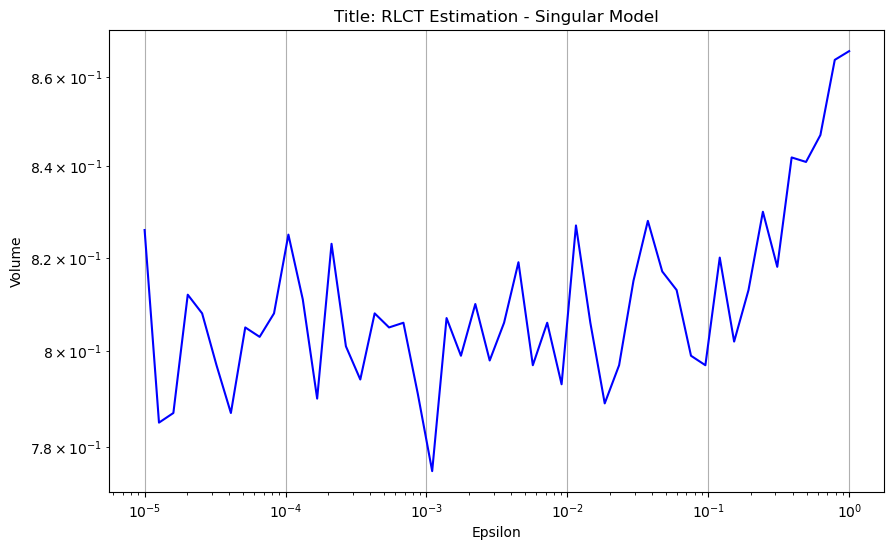

WAIC (Regular): 12103.151722550563
WAIC (Singular): 25981.371694567115


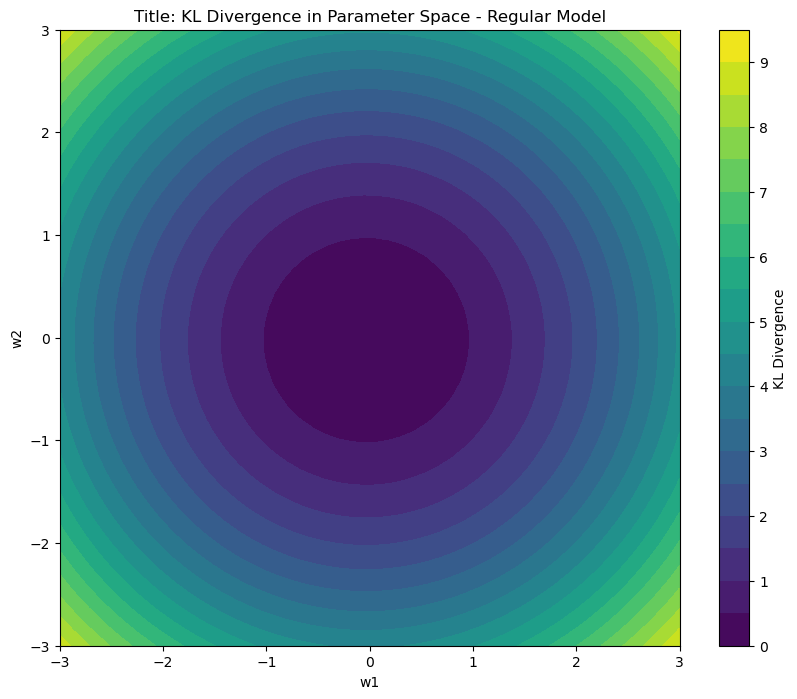

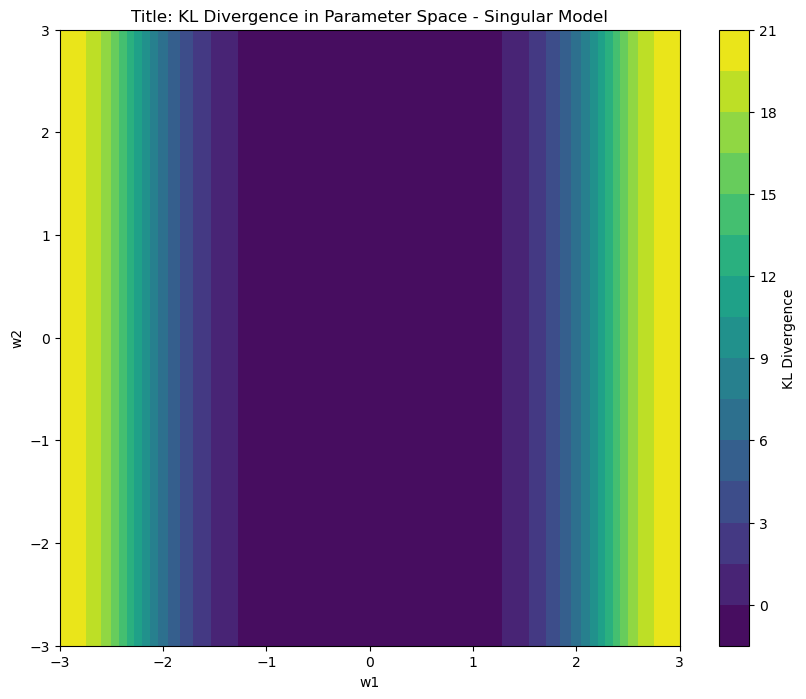

In [38]:
class SimpleGaussianModel:
    def __call__(self, x, w):
        return multivariate_normal.pdf(x, mean=w, cov=np.eye(len(w)))

class SimpleSingularModel:
    def __call__(self, x, w):
        return multivariate_normal.pdf(x[:, 0], mean=[w[0]**2], cov=[[1]])

def test_and_visualize_slt(d=2, n_samples=1000):
    def plot_rlct_estimation(slt, title):
        epsilon_range = np.logspace(-5, 0, 50)
        x = slt.true_distribution.rvs(1000)
        volumes = [slt.compute_volume(x, epsilon) for epsilon in epsilon_range]
        plt.figure(figsize=(10, 6))
        plt.loglog(epsilon_range, volumes, 'b-')
        plt.xlabel('Epsilon')
        plt.ylabel('Volume')
        plt.title(f'Title: RLCT Estimation - {title}')
        plt.grid(True)
        plt.show()
    
    def plot_kl_divergence(slt, title):
        """Visualize KL divergence in parameter space."""
        w1, w2 = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
        kl_values = np.zeros_like(w1)
        x = slt.true_distribution.rvs(1000)
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                w = np.array([w1[i, j], w2[i, j]])
                kl_values[i, j] = slt.kl_divergence(w, x)
        plt.figure(figsize=(10, 8))
        plt.contourf(w1, w2, kl_values, levels=20, cmap='viridis')
        plt.colorbar(label='KL Divergence')
        plt.xlabel('w1')
        plt.ylabel('w2')
        plt.title(f'Title: KL Divergence in Parameter Space - {title}')
        plt.show()

    # Set up the distributions and models
    true_dist = multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
    prior = multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
    regular_model = SimpleGaussianModel()
    singular_model = SimpleSingularModel()
    # Create SLT instances
    slt_regular = SingularLearningTheory(regular_model, true_dist, prior)
    slt_singular = SingularLearningTheory(singular_model, true_dist, prior)
    # Test RLCT estimation
    rlct_regular = slt_regular.estimate_rlct()
    rlct_singular = slt_singular.estimate_rlct()
    print(f"Estimated RLCT (Regular): {rlct_regular}")
    print(f"Estimated RLCT (Singular): {rlct_singular}")
    plot_rlct_estimation(slt_regular, "Regular Model")
    plot_rlct_estimation(slt_singular, "Singular Model")
    # Compute WAIC
    x_test = true_dist.rvs(1000)
    waic_regular = slt_regular.compute_waic(x_test)
    waic_singular = slt_singular.compute_waic(x_test)
    print(f"WAIC (Regular): {waic_regular}")
    print(f"WAIC (Singular): {waic_singular}")
    plot_kl_divergence(slt_regular, "Regular Model")
    plot_kl_divergence(slt_singular, "Singular Model")

test_and_visualize_slt()

From this, we note for the regular model the volume increases with epsilon, as expected. The curve is relatively smooth, especially for larger epsilon values, indicating a stable estimation of RLCT.
On the other hand, the volume remains nearly constant across all epsilon values, showing the singular model might not be capturing the singularities as intended.

Interestingly, the lower WAIC for the regular model might indicate that it has better predictive performance than the singular model.

These results highlight the complexity of working with singular models. Although they can capture interesting structures in the parameter space, we should be aware that they may not always lead to better predictive performance. This simple analysis suggests that for this particular problem and data, the regular model might be more appropriate despite not capturing the singularities in the parameter space.

We will try another example.

WAIC (Regular): 14665.119827695178
WAIC (Singular): 24001.544951863798


/var/folders/yj/sgy2qwrs3h598c90rn39dt9r0000gn/T/ipykernel_27789/2840750035.py:48: RuntimeWarning: divide by zero encountered in log
  log_volumes = np.log(volumes)


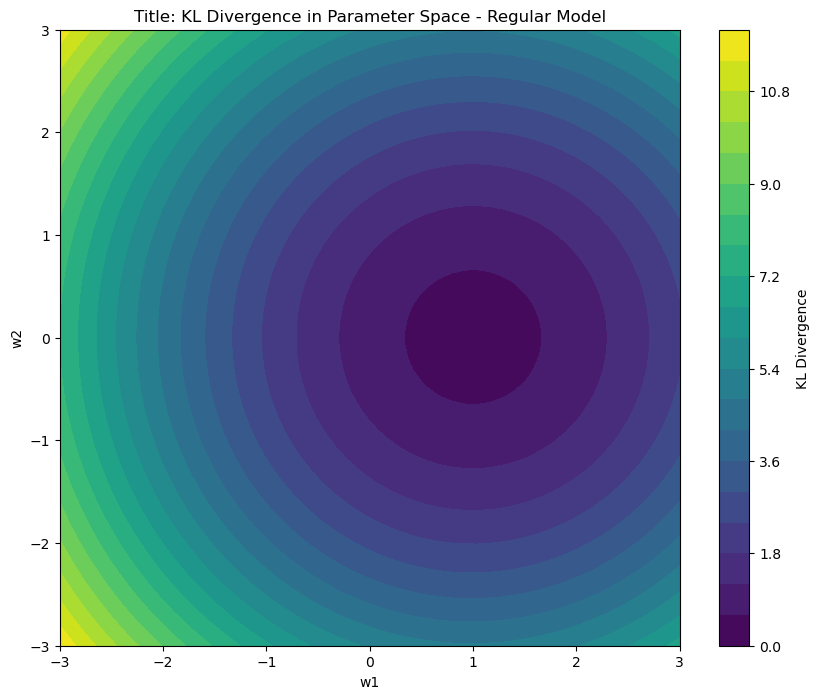

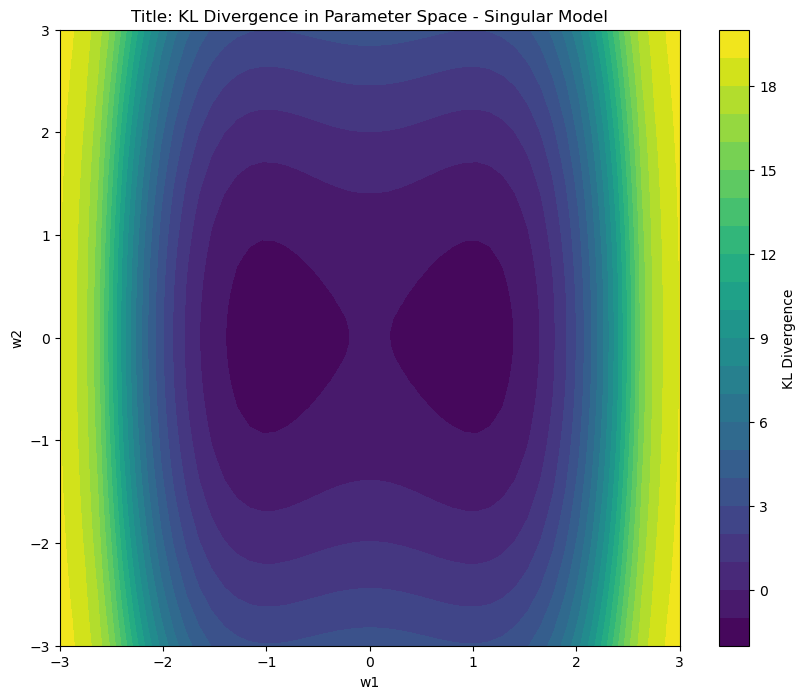

In [39]:
class RegularModel:
    def __call__(self, x, w):
        return multivariate_normal.pdf(x, mean=w, cov=np.eye(2))

class SingularModel:
    def __call__(self, x, w):
        return np.exp(-0.5 * (x[:, 0] - w[0]**2)**2 - 0.5 * (x[:, 1] - w[1])**2)

class SomeTrueDistribution:
    def rvs(self, n_samples):
        x1 = np.random.normal(0, 1, n_samples)
        x2 = np.random.normal(0, 1, n_samples)
        return np.column_stack((x1**2, x2))

    def pdf(self, x):
        return np.exp(-0.5 * x[:, 0] - 0.5 * x[:, 1]**2) / (2 * np.pi)

# Define helper methods
def true_distribution(n_samples):
    x1 = np.random.normal(0, 1, n_samples)
    x2 = np.random.normal(0, 1, n_samples)
    return np.column_stack((x1**2, x2))

def test_and_visualize_slt(n_samples=1000, n_test=1000):
    def plot_kl_divergence(slt, title):
        """Visualize KL divergence in parameter space."""
        w1, w2 = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
        kl_values = np.zeros_like(w1)
        x = true_dist.rvs(1000)
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                w = np.array([w1[i, j], w2[i, j]])
                kl_values[i, j] = slt.kl_divergence(w, x)
        plt.figure(figsize=(10, 8))
        plt.contourf(w1, w2, kl_values, levels=20, cmap='viridis')
        plt.colorbar(label='KL Divergence')
        plt.xlabel('w1')
        plt.ylabel('w2')
        plt.title(f'Title: KL Divergence in Parameter Space - {title}')
        plt.show()
    # Set up the distributions and models
    true_dist = SomeTrueDistribution()
    prior = multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
    regular_model = RegularModel()
    singular_model = SingularModel()
    # Create SLT instances
    slt_regular = SingularLearningTheory(regular_model, true_dist, prior)
    slt_singular = SingularLearningTheory(singular_model, true_dist, prior)
    # Generate training and test data
    x_train = true_dist.rvs(n_samples)
    x_test = true_dist.rvs(n_test)
    # Compute WAIC
    waic_regular = slt_regular.compute_waic(x_test)
    waic_singular = slt_singular.compute_waic(x_test)
    print(f"WAIC (Regular): {waic_regular}")
    print(f"WAIC (Singular): {waic_singular}")
    # Compute free energy for different sample sizes
    sample_sizes = np.logspace(2, 4, 10).astype(int)
    fe_regular = []
    fe_singular = []
    for n in sample_sizes:
        x = true_dist.rvs(n)
        fe_regular.append(slt_regular.compute_free_energy(x, n))
        fe_singular.append(slt_singular.compute_free_energy(x, n))
    plot_kl_divergence(slt_regular, "Regular Model")
    plot_kl_divergence(slt_singular, "Singular Model")

# Run the demonstration
test_and_visualize_slt()

This time, the singular model captures a more complex structure in the parameter space, which aligns with the true distribution's inherent singularity (x1 squared). In contrast, the regular model shows a simpler, symmetric structure that may not capture the true distribution's complexity as well.

Following the earlier example, these results seem to successfully demonstrate the strengths of the singular model when dealing with a distribution that has inherent singularities. We learn that the singular model shows a more nuanced understanding of the parameter space in these scenarios.

## 6. Conclusion

In this notebook, we have tried to explore and visualize some key concepts that are discussed in Singular Learning Theory, especially in regards to the implications it has for deep learning. For example, we learnt how regular and singular models might differ, how RLCT might affect the resulting model behavior, as well as how these theoretical insights then translate into some practical considerations we must pay attention to, like generalization error.

I think that theories like SLT are interesting and will play an important role in de-mystifying certain behaviors of complex models, and overall will help develop further interpretability in machine learning algorithms.